<a href="https://colab.research.google.com/github/klnsuman/SentimentAnalysis/blob/main/Movie_Recommenation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Required Libraries

In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

In [3]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096371 sha256=b71aa5c4f4bce95b7cde106c3255f53efc699146bde3fc663369378e213cd014
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
from math import sqrt
from scipy.sparse.linalg import svds
from surprise import Reader
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

In [5]:
import os
os.chdir("/content/drive/MyDrive/Data")

In [6]:
# Reading the ratings file.
ratings = pd.read_csv( 'ratings.csv', sep='\t', encoding='latin-1',
usecols = ['user_id', 'movie_id', 'rating'])
# Reading users file.
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1',
usecols = ['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
# Reading movies file.
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1',
usecols = ['movie_id', 'title', 'genres'])
print(ratings.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938205 entries, 0 to 938204
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   938205 non-null  int64  
 1   movie_id  938204 non-null  float64
 2   rating    938204 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 21.5 MB
None


In [7]:
ratings.head(2)

,user_id,movie_id,rating
0,1,1193.0,5.0
1,1,661.0,3.0


In [8]:
users.head(2)

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed


In [9]:
movies.head(2)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [10]:
print(users.info())
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   6040 non-null   int64 
 1   gender    6040 non-null   object
 2   zipcode   6040 non-null   object
 3   age_desc  6040 non-null   object
 4   occ_desc  6040 non-null   object
dtypes: int64(1), object(4)
memory usage: 236.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [11]:
#=================================================-
#### Slide 14: View the head of the dataset  ####

print(ratings.head(3))

print(users.head(3))

print(movies.head(3))


   user_id  movie_id  rating
0        1    1193.0     5.0
1        1     661.0     3.0
2        1     914.0     3.0
   user_id gender zipcode  age_desc       occ_desc
0        1      F   48067  Under 18   K-12 student
1        2      M   70072       56+  self-employed
2        3      M   55117     25-34      scientist
   movie_id                    title                        genres
0         1         Toy Story (1995)   Animation|Children's|Comedy
1         2           Jumanji (1995)  Adventure|Children's|Fantasy
2         3  Grumpier Old Men (1995)                Comedy|Romance


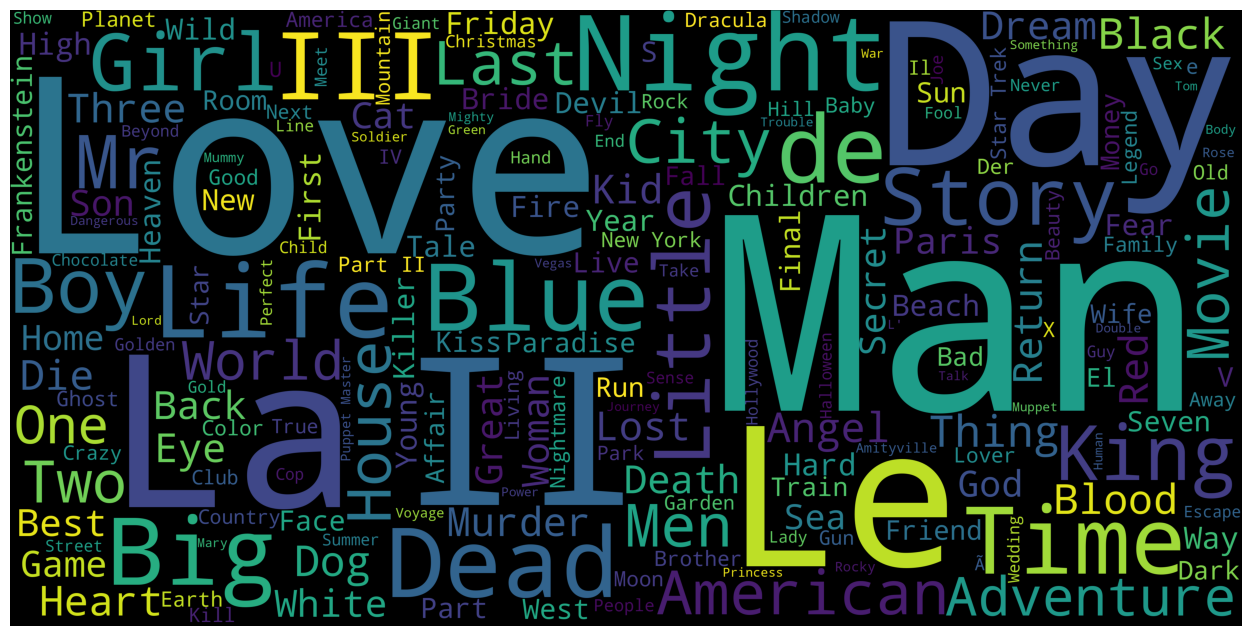

In [12]:
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black',
height = 2000, width = 4000).generate(title_corpus)

# Plot the word cloud.
plt.figure(figsize = (16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()


count    938204.000000
mean          3.580797
std           1.115932
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


<Axes: ylabel='count'>

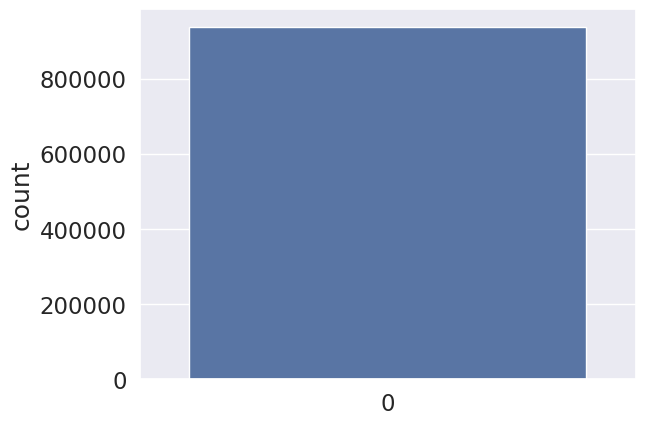

In [13]:
print(ratings['rating'].describe())
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of ratings.
sns.countplot(ratings['rating'])

In [14]:
#movies['genres'].str.split('|').values

### **Make a census of the genre keywords.**

In [15]:
dataset = pd.merge(pd.merge(movies, ratings), users)

# Display 5 movies with highest ratings.
print(dataset[['title', 'genres', 'rating']].sort_values('rating', ascending = False).head(5))
# Make a census of the genre keywords.
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

                                            title  \
0                                Toy Story (1995)   
457444                           Toy Story (1995)   
457488                        Pulp Fiction (1994)   
457483  Star Wars: Episode IV - A New Hope (1977)   
457473          Die Hard: With a Vengeance (1995)   

                                 genres  rating  
0           Animation|Children's|Comedy     5.0  
457444      Animation|Children's|Comedy     5.0  
457488                      Crime|Drama     5.0  
457483  Action|Adventure|Fantasy|Sci-Fi     5.0  
457473                  Action|Thriller     5.0  


In [16]:
movies['genres'].unique()[:10]

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance'], dtype=object)

### **Create a function that counts the number of times each of the genre keywords appear.**

In [17]:
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1
    # Convert the dictionary in a list to sort the keywords by frequency.
    keyword_occurrences = []
    for k,v in keyword_count.items():
        keyword_occurrences.append([k,v])
    keyword_occurrences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurrences, keyword_count


In [18]:
keyword_occurrences, dum = count_word(movies, 'genres', genre_labels)
print(keyword_occurrences[:5])

[['Drama', 1603], ['Comedy', 1200], ['Action', 503], ['Thriller', 492], ['Romance', 471]]


In [19]:
# Break up the big genre string into a string array.
movies['genres'] = movies['genres'].str.split('|')

# Convert genres to string values.
movies['genres'] = movies['genres'].fillna("").astype('str')
print(movies['genres'].head())


0     ['Animation', "Children's", 'Comedy']
1    ['Adventure', "Children's", 'Fantasy']
2                     ['Comedy', 'Romance']
3                       ['Comedy', 'Drama']
4                                ['Comedy']
Name: genres, dtype: object


In [20]:
genre_labels

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [21]:
movies.shape, ratings.shape, users.shape

((3883, 3), (938205, 3), (6040, 5))

In [22]:
movies.columns, ratings.columns,users.columns

(Index(['movie_id', 'title', 'genres'], dtype='object'),
 Index(['user_id', 'movie_id', 'rating'], dtype='object'),
 Index(['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'], dtype='object'))

In [23]:
tf = TfidfVectorizer(analyzer = 'word',
ngram_range = (1, 2),
min_df = 0,
stop_words = 'english')

tfidf_matrix = tf.fit_transform(movies['genres'])
print(tfidf_matrix.shape)

(3883, 127)


In [24]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim[:4, :4])

print(cosine_sim.shape)
# Build a 1-dimensional array with movie titles.
titles = movies['title']
indices = pd.Series(movies.index, index = movies['title'])
print(titles[0:5])


[[1.         0.14193614 0.09010857 0.1056164 ]
 [0.14193614 1.         0.         0.        ]
 [0.09010857 0.         1.         0.1719888 ]
 [0.1056164  0.         0.1719888  1.        ]]
(3883, 3883)
0                      Toy Story (1995)
1                        Jumanji (1995)
2               Grumpier Old Men (1995)
3              Waiting to Exhale (1995)
4    Father of the Bride Part II (1995)
Name: title, dtype: object


In [26]:
indices

title
Toy Story (1995)                         0
Jumanji (1995)                           1
Grumpier Old Men (1995)                  2
Waiting to Exhale (1995)                 3
Father of the Bride Part II (1995)       4
                                      ... 
Meet the Parents (2000)               3878
Requiem for a Dream (2000)            3879
Tigerland (2000)                      3880
Two Family House (2000)               3881
Contender, The (2000)                 3882
Length: 3883, dtype: int64

In [27]:
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [28]:

#=================================================-
#### Slide 33: Content based recommender implementation - cont'd  ####

print(genre_recommendations('Toy Story (1995)').head(20))


1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [29]:
print(genre_recommendations('Aladdin and the King of Thieves (1996)').head(20))


1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          